<a href="https://colab.research.google.com/github/ricedavis/CSCE580-Fall2025/blob/main/Quiz1/Q3_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# a. Data Issues

In [199]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [200]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [201]:
df = pd.read_csv('/content/drive/MyDrive/Redacted-Department _ CAD Reconciliation.csv')

In [202]:
df.head()

,XREF ID,DISPATCH UNIT,DISPATCH CREATED DATE,INCIDENT NUMBER,1ST UNIT ON SCENE,ALARM DATE TIME,CALL COMPLETE,SHIFT
0,2025107105,"BAT111, E171, LDR175",3/24/25 15:54,25-1368,BC-111,3/24/25 15:46,9/5/25 16:20,C
1,2025107223,BAT111,3/24/25 17:28,25-1369,BC-111,3/24/25 17:23,9/5/25 17:55,C
2,2025107415,E171,3/24/25 21:03,25-1370,E-171,3/24/25 21:02,9/4/25 21:09,C
3,2025107411,E171,3/24/25 21:03,25-1371,NaN,3/24/25 20:58,9/4/25 21:02,C
4,2025107384,"BAT111, E171, LDR175",3/24/25 21:43,25-1374,BC-111,3/24/25 20:30,9/4/25 21:36,C


## 1. Range of Data

In [203]:
df['DISPATCH CREATED DATE'] = pd.to_datetime(df['DISPATCH CREATED DATE'], errors = 'coerce')

/tmp/ipython-input-3650422554.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DISPATCH CREATED DATE'] = pd.to_datetime(df['DISPATCH CREATED DATE'], errors = 'coerce')


In [204]:
# Calculate the range of data by taking the last entry time minus the first entry time
print(f"min: {df['DISPATCH CREATED DATE'].min()}, max: {df['DISPATCH CREATED DATE'].max()}")
time_range = df['DISPATCH CREATED DATE'].max() - df['DISPATCH CREATED DATE'].min()
time_range

min: 2025-03-24 15:54:00, max: 2025-08-31 23:03:00


Timedelta('160 days 07:09:00')

The range of data is from 2025-03-24 15:54:00 to 2025-08-31 23:03:00, the total change in time being 160 days, 7 hours and 9 minutes.

## 2. Percent of data missing from each column

In [205]:
# Find number of null values for each column
df.isna().sum()

,0
XREF ID,0
DISPATCH UNIT,0
DISPATCH CREATED DATE,0
INCIDENT NUMBER,0
1ST UNIT ON SCENE,428
ALARM DATE TIME,31
CALL COMPLETE,31
SHIFT,69


In [206]:
# Amount of values that should be in each column
len(df)

# Calculate percent of missing values per column
def calc_percent(column):
  percent_missing = df[column].isna().sum()/2200*100
  return f"{column} percent of missing values = {percent_missing:.2f}%"

for column in df:
  result = calc_percent(column)
  print(result)

XREF ID percent of missing values = 0.00%
DISPATCH UNIT percent of missing values = 0.00%
DISPATCH CREATED DATE percent of missing values = 0.00%
INCIDENT NUMBER percent of missing values = 0.00%
1ST UNIT ON SCENE percent of missing values = 19.45%
ALARM DATE TIME percent of missing values = 1.41%
CALL COMPLETE percent of missing values = 1.41%
SHIFT percent of missing values = 3.14%


Calculated the percent of missing values for each column, with the column '1ST UNIT ON SCENE' having the highest rate of missing values.

## 3. Identifying Issues in the Data

Based on the prior task, we know that there are lots of **missing values**, that is one issue with the data.

In [207]:
df.dtypes

,0
XREF ID,int64
DISPATCH UNIT,object
DISPATCH CREATED DATE,datetime64[ns]
INCIDENT NUMBER,object
1ST UNIT ON SCENE,object
ALARM DATE TIME,object
CALL COMPLETE,object
SHIFT,object


In [208]:
df.head()

,XREF ID,DISPATCH UNIT,DISPATCH CREATED DATE,INCIDENT NUMBER,1ST UNIT ON SCENE,ALARM DATE TIME,CALL COMPLETE,SHIFT
0,2025107105,"BAT111, E171, LDR175",2025-03-24 15:54:00,25-1368,BC-111,3/24/25 15:46,9/5/25 16:20,C
1,2025107223,BAT111,2025-03-24 17:28:00,25-1369,BC-111,3/24/25 17:23,9/5/25 17:55,C
2,2025107415,E171,2025-03-24 21:03:00,25-1370,E-171,3/24/25 21:02,9/4/25 21:09,C
3,2025107411,E171,2025-03-24 21:03:00,25-1371,NaN,3/24/25 20:58,9/4/25 21:02,C
4,2025107384,"BAT111, E171, LDR175",2025-03-24 21:43:00,25-1374,BC-111,3/24/25 20:30,9/4/25 21:36,C


Some issues highlighted here are that some columns which represent dates are not in the proper datetime format for manipulation. "ALARM DATE TIME" and "CALL COMPLETE" are examples of these columns.

Other formatting issues can be found within the "DISPATCH UNIT" column, where some rows include different units seperated by commas. This inconsistency can make it tricky to analyze.

Logical errors may exist as well. It is important to check that the value in the "CALL COMPLETE" column does not exceed the "ALARM DATE TIME" as that wouldn't make sense in this context.

Finally, it's important to check for duplicates within the data as well.

## 4. Resolving Data Issues

In [209]:
# Start by fixing data types
df['ALARM DATE TIME'] = pd.to_datetime(df['ALARM DATE TIME'], errors = 'coerce')
df['CALL COMPLETE'] = pd.to_datetime(df['CALL COMPLETE'], errors = 'coerce')

/tmp/ipython-input-3653844370.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ALARM DATE TIME'] = pd.to_datetime(df['ALARM DATE TIME'], errors = 'coerce')
/tmp/ipython-input-3653844370.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CALL COMPLETE'] = pd.to_datetime(df['CALL COMPLETE'], errors = 'coerce')


In [210]:
# Check for logical errors in timestamps
df[df['CALL COMPLETE'] < df['ALARM DATE TIME']]
# Returns empty df so no issues here

,XREF ID,DISPATCH UNIT,DISPATCH CREATED DATE,INCIDENT NUMBER,1ST UNIT ON SCENE,ALARM DATE TIME,CALL COMPLETE,SHIFT


In [211]:
# Check for duplicates
df.duplicated().sum()
# No duplicate rows in the dataset

np.int64(0)

Assigning ID's to cases:

In [212]:
# Add a new unique ID column starting from 1
df.insert(0, "ID", range(1, len(df) + 1))


Dealing with missing values/data:

In [213]:
df.isna().sum()

,0
ID,0
XREF ID,0
DISPATCH UNIT,0
DISPATCH CREATED DATE,0
INCIDENT NUMBER,0
1ST UNIT ON SCENE,428
ALARM DATE TIME,31
CALL COMPLETE,31
SHIFT,69


Replacing missing 1st unit on the scene with 'UNKNOWN' because it is categorical data.

In [214]:
# If there was not a first unit on the scene, no first unit arrived based on the alarm date times and call completes.
# Likely attributed to hoaxes or non-emergencies that did not require a dispatch to arrive.
# I will choose to replace nulls with "UKNOWN", as there could be failed data entry as well.
df['1ST UNIT ON SCENE'] = df['1ST UNIT ON SCENE'].fillna("UNKNOWN")
df['1ST UNIT ON SCENE'].value_counts()

,count
1ST UNIT ON SCENE,
L-175,740
E-171,507
UNKNOWN,428
E-172,409
BC-111,96
C-102,7
M-105,4
SRT-117,3
C-103,2


In [215]:
# This line proves that the alarm date time and call complete values are both null at the same time
len(df[df['ALARM DATE TIME'].isna() & df['CALL COMPLETE'].isna()])

31

Time stamps will be replaced with their average difference from "DISPATCH CREATED DATE" column

In [216]:
# Replace ALARM DATE TIME with average difference between DISPATCH CREATED DATE and ALARM DATE TIME of recorded values
# Replace CALL COMPLETE with average difference between DISPATCH CREATED DATE and CALL COMPLETE of recorded values

# For ALARM DATE TIME
alarm_diffs = (df["ALARM DATE TIME"] - df["DISPATCH CREATED DATE"]).dropna()
avg_alarm_diff = alarm_diffs.mean()

# For CALL COMPLETE
complete_diffs = (df["CALL COMPLETE"] - df["DISPATCH CREATED DATE"]).dropna()
avg_complete_diff = complete_diffs.mean()

df.loc[df["ALARM DATE TIME"].isna(), "ALARM DATE TIME"] = (
    df.loc[df["ALARM DATE TIME"].isna(), "DISPATCH CREATED DATE"] + avg_alarm_diff
)

df.loc[df["CALL COMPLETE"].isna(), "CALL COMPLETE"] = (
    df.loc[df["CALL COMPLETE"].isna(), "DISPATCH CREATED DATE"] + avg_complete_diff
)


At first I thought that shifts may be able to be calculated based on the time of day but...

In [217]:
df["HOUR"] = df["DISPATCH CREATED DATE"].dt.hour

shift_hours = df.groupby("SHIFT")["HOUR"].describe()
print(shift_hours)

       count       mean       std  min   25%   50%   75%   max
SHIFT                                                         
A      735.0  13.458503  5.879638  0.0  10.0  14.0  18.0  23.0
B      677.0  13.567208  5.776174  0.0  10.0  14.0  18.0  23.0
C      719.0  13.150209  6.030306  0.0   9.0  14.0  18.0  23.0


Looking at the min and max values, we can see that the shifts are not assigned by time of day. In that case, we will treat the shifts as categorical and set them as "UNKNOWN"

In [218]:
df['SHIFT'] = df['SHIFT'].fillna('UNKNOWN')

In [219]:
df.isna().sum()
# Finally we have no more null values:

,0
ID,0
XREF ID,0
DISPATCH UNIT,0
DISPATCH CREATED DATE,0
INCIDENT NUMBER,0
1ST UNIT ON SCENE,0
ALARM DATE TIME,0
CALL COMPLETE,0
SHIFT,0
HOUR,0


# b. Exploratory Data Analysis

## 1. Average time for an alarm to be resolved

In [220]:
df['CALL DURATION'] = df['CALL COMPLETE'] - df['ALARM DATE TIME']
avg_duration = df['CALL DURATION'].mean()
avg_duration


Timedelta('90 days 18:28:08.907330567')

On average, a call takes 90 days, 18 hours, 28 minutes and 8 seconds from the alarm going off to the call being complete.

## 2. Number of Fire Units, on average, that are usually sent for a fire alarm

In [221]:
df.dtypes

,0
ID,int64
XREF ID,int64
DISPATCH UNIT,object
DISPATCH CREATED DATE,datetime64[ns]
INCIDENT NUMBER,object
1ST UNIT ON SCENE,object
ALARM DATE TIME,datetime64[ns]
CALL COMPLETE,datetime64[ns]
SHIFT,object
HOUR,int32


In [222]:
# Fix dispatch unit column to be split into a list
df['DISPATCH UNIT'] = df['DISPATCH UNIT'].astype(str)
df['DISPATCH UNIT'] = df['DISPATCH UNIT'].str.split(", ")

df['NUMBER OF UNITS'] = df['DISPATCH UNIT'].apply(len)
avg_num_of_units = df['NUMBER OF UNITS'].mean()
avg_num_of_units

np.float64(1.440909090909091)

Average number of units sent for a fire alarm is 1.441 units.

## 3. Which shift is busiest between A, B and C

In [223]:
df['SHIFT'].value_counts()

,count
SHIFT,
A,735
C,719
B,677
UNKNOWN,69


By looking at the value counts, we see that **shift A** has the most occurances (735) in the dataset, making them the busiest.

## 4. Matrix of number of file alarms organized by the day of the week and hour of the day

In [224]:
# Ensure datetime
df['DISPATCH CREATED DATE'] = pd.to_datetime(df['DISPATCH CREATED DATE'])

# Extract hour (0–23)
df['HOUR'] = df['DISPATCH CREATED DATE'].dt.hour

# Extract day of week (0=Monday, 6=Sunday)
df['DAY_OF_WEEK'] = df['DISPATCH CREATED DATE'].dt.day_name()


In [225]:
# Count number of dispatches per day-of-week and hour
matrix = pd.pivot_table(
    df,
    values='ID',
    index='HOUR',               # y-axis
    columns='DAY_OF_WEEK',      # x-axis
    aggfunc='count',
    margins=True,
    margins_name='Total'
)

matrix


DAY_OF_WEEK,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Total
HOUR,,,,,,,,
0,3,8,7,4,2,8,6,38
1,3,11,8,10,8,8,7,55
2,4,4,8,8,3,5,3,35
3,9,9,4,9,1,10,8,50
4,7,4,6,4,2,4,4,31
5,6,9,4,5,4,3,8,39
6,10,4,6,10,7,5,7,49
7,14,15,5,10,11,15,8,78
8,8,13,7,14,8,13,18,81


# c. Unsupervised Learning

## 1. Clustering data

Kmeans clustering:

In [226]:
df['CALL DURATION'] = (df['CALL COMPLETE'] - df['DISPATCH CREATED DATE']).dt.total_seconds() / 60
features = df[['NUMBER OF UNITS', 'CALL DURATION']].fillna(0)

In [227]:
scaler = StandardScaler()
X = scaler.fit_transform(features)

In [228]:
# Fit KMeans with 3 clusters (example)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Evaluate quality
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"K-Means silhouette score: {kmeans_silhouette:.3f}")


K-Means silhouette score: 0.494


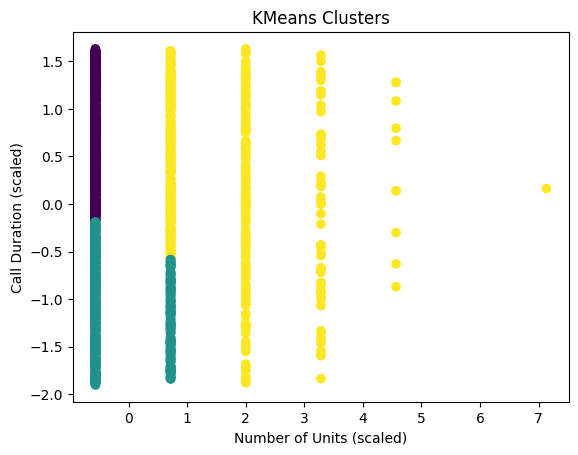

In [229]:
plt.scatter(X[:,0], X[:,1], c=kmeans_labels, cmap='viridis', label='KMeans')
plt.xlabel('Number of Units (scaled)')
plt.ylabel('Call Duration (scaled)')
plt.title('KMeans Clusters')
plt.show()

Agglomerative Clustering:

In [230]:
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X)

# Evaluate quality
agg_silhouette = silhouette_score(X, agg_labels)
print(f"Agglomerative clustering silhouette score: {agg_silhouette:.3f}")


Agglomerative clustering silhouette score: 0.488


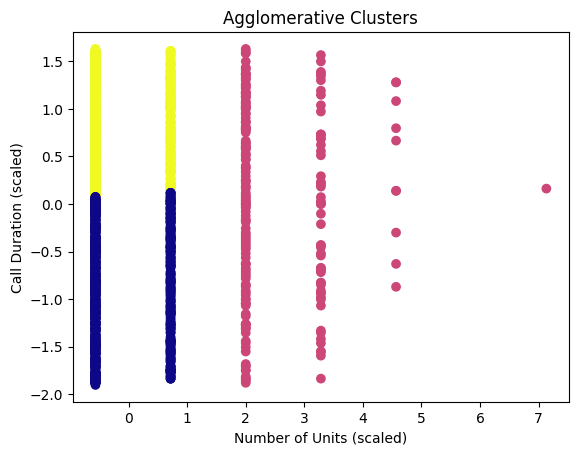

In [231]:
plt.scatter(X[:,0], X[:,1], c=agg_labels, cmap='plasma', label='Agglomerative')
plt.xlabel('Number of Units (scaled)')
plt.ylabel('Call Duration (scaled)')
plt.title('Agglomerative Clusters')
plt.show()


Kmeans clustering performed better with a score of .494 while agglomerative clustering returned a score of 0.488.

## 2. Best result interpretation

In [234]:
# Attach cluster labels to df:
df['CLUSTER'] = kmeans_labels

In [237]:
cluster_summary = df.groupby('CLUSTER')[['NUMBER OF UNITS', 'CALL DURATION']].mean()
cluster_summary

,NUMBER OF UNITS,CALL DURATION
CLUSTER,,
0,1.000000,179381.843106
1,1.184852,60867.301669
2,2.570342,150899.012204


The call durations are incredibly long, likely due to the fact that the Call Complete column must be either incorrect or including administrative delays. Many values are up to 4 months ahead of the initial alarm going off.

Regardless, the clusters may be interpreted this way:

- Cluster 0: Sending 1 unit could lead to unusually long closures, there could also be some outliers in this cluster altering the data.
- Cluster 1: Represents the typical fire call, where 1 or 2 units are sent and the duration is relatively small.
- Cluster 2: Represents larger calls requiring more units, and can take a much longer time to be resolved